<a href="https://colab.research.google.com/github/KrystalXL/Kaggle--optiver/blob/main/optiver_lightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 7.7 MB/s eta 0:00:00


In [2]:
pip install neptune

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 495.5/495.5 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.9/63.9 kB 6.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.9/137.9 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 6.1 MB/s eta 0:00:00
  Created wheel for bravado-core: filename=bravado_core-6.1.1-py2.py3-none-any.whl size=67672 sha256=f79fdd24027e5817c30107658121e69ae3451ae711094a94fbdcc6ac25839a37
  Stored in directory: /root/.cache/pip/wheels/42/35/4a/44ec4c

In [3]:
import lightgbm

# 新段落

In [4]:
import os
import sys
import glob
from joblib import Parallel, delayed
import pandas as pd
import numpy as np
import scipy as sc
from sklearn.model_selection import KFold
import lightgbm as lgb
import warnings
import random
import joblib
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import optuna
import neptune.new as neptune
from optuna.samplers import TPESampler
from collections import Counter, defaultdict
from sklearn import model_selection
from neptune.new.types import File
import time
random.seed(42)
os.environ['PYTHONHASHSEED'] = str(42)
np.random.seed(42)
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 300)


[neptune] [warning] NeptuneDeprecationWarning: You're importing the Neptune client library via the deprecated `neptune.new` module, which will be removed in a future release. Import directly from `neptune` instead.


In [5]:
from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/My Drive/optiver-realized-volatility-prediction'
output_dir = "/content/drive/My Drive/output"

def init_logger(log_file=output_dir+'/train.log'):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    import os

    # 确保输出目录存在，如果不存在，则创建
    os.makedirs(output_dir, exist_ok=True)

    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

# 其他函数定义

LOGGER = init_logger()


Mounted at /content/drive


In [6]:

# Function to calculate first WAP
def calc_wap1(df):
    wap = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

# Function to calculate second WAP
def calc_wap2(df):
    wap = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

def calc_wap3(df):
    wap = (df['bid_price1'] * df['bid_size1'] + df['ask_price1'] * df['ask_size1']) / (df['bid_size1'] + df['ask_size1'])
    return wap

def calc_wap4(df):
    wap = (df['bid_price2'] * df['bid_size2'] + df['ask_price2'] * df['ask_size2']) / (df['bid_size2'] + df['ask_size2'])
    return wap

# Function to calculate the log of the return
# Remember that logb(x / y) = logb(x) - logb(y)
def log_return(series):
    return np.log(series).diff()

# Calculate the realized volatility
def realized_volatility(series):
    return np.sqrt(np.sum(series**2))

# Function to count unique elements of a series
def count_unique(series):
    return len(np.unique(series))

# Function to read our base train and test set
def read_train_test():
    train_path = os.path.join(data_dir, 'train.csv')
    test_path = os.path.join(data_dir, 'test.csv')
    train = pd.read_csv(train_path)
    test = pd.read_csv(test_path)
    # Create a key to merge with book and trade data
    train['row_id'] = train['stock_id'].astype(str) + '-' + train['time_id'].astype(str)
    test['row_id'] = test['stock_id'].astype(str) + '-' + test['time_id'].astype(str)
    print(f'Our training set has {train.shape[0]} rows')
    return train, test

# Function to preprocess book data (for each stock id)
def book_preprocessor(data_dir):
    df = pd.read_parquet(data_dir)

    # Calculate Wap
    df['wap1'] = calc_wap1(df)
    df['wap2'] = calc_wap2(df)
    df['wap3'] = calc_wap3(df) #### 加入了wap3
    df['wap4'] = calc_wap4(df) #### 加入了wap4
    # Calculate log returns
    df['log_return1'] = df.groupby(['time_id'])['wap1'].apply(log_return)
    df['log_return2'] = df.groupby(['time_id'])['wap2'].apply(log_return)
    df['log_return3'] = df.groupby(['time_id'])['wap3'].apply(log_return)
    df['log_return4'] = df.groupby(['time_id'])['wap4'].apply(log_return)
    # Calculate wap balance
    df['wap_balance'] = abs(df['wap1'] - df['wap2'])
    # Calculate spread
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1']) / 2)
    df['price_spread2'] = (df['ask_price2'] - df['bid_price2']) / ((df['ask_price2'] + df['bid_price2']) / 2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    df["bid_ask_spread"] = abs(df['bid_spread'] - df['ask_spread'])
    df['total_volume'] = (df['ask_size1'] + df['ask_size2']) + (df['bid_size1'] + df['bid_size2'])
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))

    # Dict for aggregations
    create_feature_dict = {
        'wap1': [np.sum, np.std],               #### 去掉np.mean
        'wap2': [np.sum, np.std],               #### 去掉np.mean
        'wap3': [np.sum, np.std],               #### 加入wap3 [np.sum, np.std]
        'wap4': [np.sum, np.std],               #### 加入wap4 [np.sum, np.std]
        'log_return1': [realized_volatility],   #### 去掉np.sum, np.mean, np.std
        'log_return2': [realized_volatility],   #### 去掉np.sum, np.mean, np.std
        'log_return3': [realized_volatility],   #### 加入 'log_return3': [realized_volatility]
        'log_return4': [realized_volatility],   #### 加入 'log_return4': [realized_volatility]
        'wap_balance': [np.sum, np.max],        #### 去掉np.mean, np.std,加入了np.max
        'price_spread':[np.sum, np.max],        #### 去掉np.mean, np.std,加入了np.max
        'price_spread2':[np.sum, np.max],       #### 去掉np.mean, np.std,加入了np.max
        'bid_spread':[np.sum, np.max],          #### 去掉np.mean, np.std,加入了np.max
        'ask_spread':[np.sum, np.max],          #### 去掉np.mean, np.std,加入了np.max
        'total_volume':[np.sum, np.max],        #### 去掉np.mean, np.std,加入了np.max
        'volume_imbalance':[np.sum, np.max],    #### 去掉np.mean, np.std,加入了np.max
        "bid_ask_spread":[np.sum,  np.max],     #### 去掉np.mean, np.std,加入了np.max
    }

    #### 新增create_feature_dict_time特征组，用作windows
    create_feature_dict_time = {
        'log_return1': [realized_volatility],
        'log_return2': [realized_volatility],
        'log_return3': [realized_volatility],
        'log_return4': [realized_volatility],
    }


    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict, seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature

    # Get the stats for different windows
    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    #### 用100,200,300,400,500代替原来的150,300,450。并且精简特征，用create_feature_dict_time
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)

    # Merge all
    #### 用100,200,300,400,500代替原来的150,300,450
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')
    # Drop unnecesary time_ids
    #### 用100,200,300,400,500代替原来的150,300,450
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id__100'], axis = 1, inplace = True)

    # Create row_id so we can merge
    stock_id = data_dir.split('=')[1]
    df_feature['row_id'] = df_feature['time_id_'].apply(lambda x: f'{stock_id}-{x}')
    df_feature.drop(['time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to preprocess trade data (for each stock id)
def trade_preprocessor(data_dir):
    df = pd.read_parquet(data_dir)
    df['log_return'] = df.groupby('time_id')['price'].apply(log_return)
    df['amount']=df['price']*df['size']      #### 新增特征amount
    # Dict for aggregations
    create_feature_dict = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum, np.max, np.min],    #### 删掉realized_volatility, np.mean, np.std
        'order_count':[np.sum,np.max],      #### 删掉np.mean
        'amount':[np.sum,np.max,np.min],    #### 加入'amount':[np.sum,np.max,np.min]
    }

    #### 新增create_feature_dict_time特征组，用作windows
    create_feature_dict_time = {
        'log_return':[realized_volatility],
        'seconds_in_bucket':[count_unique],
        'size':[np.sum],
        'order_count':[np.sum],
    }

    # Function to get group stats for different windows (seconds in bucket)
    def get_stats_window(fe_dict, seconds_in_bucket, add_suffix = False):
        # Group by the window
        df_feature = df[df['seconds_in_bucket'] >= seconds_in_bucket].groupby(['time_id']).agg(fe_dict).reset_index()
        # Rename columns joining suffix
        df_feature.columns = ['_'.join(col) for col in df_feature.columns]
        # Add a suffix to differentiate windows
        if add_suffix:
            df_feature = df_feature.add_suffix('_' + str(seconds_in_bucket))
        return df_feature

    df_feature = get_stats_window(create_feature_dict,seconds_in_bucket = 0, add_suffix = False)
    #### 用100,200,300,400,500代替原来的150,300,450。并且精简特征，用create_feature_dict_time
    df_feature_500 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 500, add_suffix = True)
    df_feature_400 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 400, add_suffix = True)
    df_feature_300 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 300, add_suffix = True)
    df_feature_200 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 200, add_suffix = True)
    df_feature_100 = get_stats_window(create_feature_dict_time,seconds_in_bucket = 100, add_suffix = True)


    def tendency(price, vol):
        df_diff = np.diff(price)
        val = (df_diff/price[1:])*100
        power = np.sum(val*vol[1:])
        return(power)

    lis = []
    for n_time_id in df['time_id'].unique():
        df_id = df[df['time_id'] == n_time_id]
        tendencyV = tendency(df_id['price'].values, df_id['size'].values)
        f_max = np.sum(df_id['price'].values > np.mean(df_id['price'].values))
        f_min = np.sum(df_id['price'].values < np.mean(df_id['price'].values))
        df_max =  np.sum(np.diff(df_id['price'].values) > 0)
        df_min =  np.sum(np.diff(df_id['price'].values) < 0)
        # new
        abs_diff = np.median(np.abs( df_id['price'].values - np.mean(df_id['price'].values)))
        energy = np.mean(df_id['price'].values**2)
        iqr_p = np.percentile(df_id['price'].values,75) - np.percentile(df_id['price'].values,25)

        # vol vars

        abs_diff_v = np.median(np.abs( df_id['size'].values - np.mean(df_id['size'].values)))
        energy_v = np.sum(df_id['size'].values**2)
        iqr_p_v = np.percentile(df_id['size'].values,75) - np.percentile(df_id['size'].values,25)

        lis.append({'time_id':n_time_id,'tendency':tendencyV,'f_max':f_max,'f_min':f_min,'df_max':df_max,'df_min':df_min,
                   'abs_diff':abs_diff,'energy':energy,'iqr_p':iqr_p,'abs_diff_v':abs_diff_v,'energy_v':energy_v,'iqr_p_v':iqr_p_v})

    df_lr = pd.DataFrame(lis)
    df_feature = df_feature.merge(df_lr, how = 'left', left_on = 'time_id_', right_on = 'time_id')

    # Merge all
    #### 用100,200,300,400,500代替原来的150,300,450
    df_feature = df_feature.merge(df_feature_500, how = 'left', left_on = 'time_id_', right_on = 'time_id__500')
    df_feature = df_feature.merge(df_feature_400, how = 'left', left_on = 'time_id_', right_on = 'time_id__400')
    df_feature = df_feature.merge(df_feature_300, how = 'left', left_on = 'time_id_', right_on = 'time_id__300')
    df_feature = df_feature.merge(df_feature_200, how = 'left', left_on = 'time_id_', right_on = 'time_id__200')
    df_feature = df_feature.merge(df_feature_100, how = 'left', left_on = 'time_id_', right_on = 'time_id__100')

    #### 用100,200,300,400,500代替原来的150,300,450
    df_feature.drop(['time_id__500','time_id__400', 'time_id__300', 'time_id__200','time_id','time_id__100'], axis = 1, inplace = True)


    df_feature = df_feature.add_prefix('trade_')
    stock_id = data_dir.split('=')[1]
    df_feature['row_id'] = df_feature['trade_time_id_'].apply(lambda x:f'{stock_id}-{x}')
    df_feature.drop(['trade_time_id_'], axis = 1, inplace = True)
    return df_feature

# Function to get group stats for the stock_id and time_id
def get_time_stock(df):
    # Get realized volatility columns
    #### 用200和400替换150和450
    vol_cols = ['log_return1_realized_volatility', 'log_return2_realized_volatility', 'log_return1_realized_volatility_400', 'log_return2_realized_volatility_400',
            'log_return1_realized_volatility_300', 'log_return2_realized_volatility_300', 'log_return1_realized_volatility_200', 'log_return2_realized_volatility_200',
            'trade_log_return_realized_volatility', 'trade_log_return_realized_volatility_400', 'trade_log_return_realized_volatility_300', 'trade_log_return_realized_volatility_200']

    # Group by the stock id
    df_stock_id = df.groupby(['stock_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_stock_id.columns = ['_'.join(col) for col in df_stock_id.columns]
    df_stock_id = df_stock_id.add_suffix('_' + 'stock')

    # Group by the stock id
    df_time_id = df.groupby(['time_id'])[vol_cols].agg(['mean', 'std', 'max', 'min', ]).reset_index()
    # Rename columns joining suffix
    df_time_id.columns = ['_'.join(col) for col in df_time_id.columns]
    df_time_id = df_time_id.add_suffix('_' + 'time')

    # Merge with original dataframe
    df = df.merge(df_stock_id, how = 'left', left_on = ['stock_id'], right_on = ['stock_id__stock'])
    df = df.merge(df_time_id, how = 'left', left_on = ['time_id'], right_on = ['time_id__time'])
    df.drop(['stock_id__stock', 'time_id__time'], axis = 1, inplace = True)
    return df

import os
import pandas as pd
from joblib import Parallel, delayed

def preprocessor(list_stock_ids, is_train = True):
    def for_joblib(stock_id):
        # Train
        if is_train:
            file_path_book = os.path.join(data_dir, f"book_train.parquet/stock_id={stock_id}")
            file_path_trade = os.path.join(data_dir, f"trade_train.parquet/stock_id={stock_id}")
        # Test
        else:
            file_path_book = os.path.join(data_dir, f"book_test.parquet/stock_id={stock_id}")
            file_path_trade = os.path.join(data_dir, f"trade_test.parquet/stock_id={stock_id}")

        # Preprocess book and trade data and merge them
        df_tmp = pd.merge(book_preprocessor(file_path_book), trade_preprocessor(file_path_trade), on = 'row_id', how = 'left')

        # Return the merge dataframe
        return df_tmp

    # Use parallel api to call parallel for loop
    df = Parallel(n_jobs = -1, verbose = 1)(delayed(for_joblib)(stock_id) for stock_id in list_stock_ids)
    # Concatenate all the dataframes that return from Parallel
    df = pd.concat(df, ignore_index = True)
    return df


def rmspe(y_true, y_pred):
    return np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))


def feval_rmspe(y_pred, lgb_train):
    y_true = lgb_train.get_label()
    return 'RMSPE', rmspe(y_true, y_pred), False

In [7]:
# Read train and test
train, test = read_train_test()
train_stock_ids = train['stock_id'].unique()
train_ = preprocessor(train_stock_ids, is_train = True)
train = train.merge(train_, on = ['row_id'], how = 'left')

# Get unique stock ids
test_stock_ids = test['stock_id'].unique()
# Preprocess them using Parallel and our single stock id functions
test_ = preprocessor(test_stock_ids, is_train = False)
test = test.merge(test_, on = ['row_id'], how = 'left')

train = get_time_stock(train)
test = get_time_stock(test)

Our training set has 428932 rows


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  3.6min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 40 concurrent workers.


In [8]:
# Make sure 'file_path_book' points to a Parquet file and not a CSV file
file_path_book = '/content/drive/My Drive/optiver-realized-volatility-prediction/book_train.parquet/stock_id=4'

# Try reading the entire Parquet file without specifying columns
df_sample = pd.read_parquet(file_path_book)
print(df_sample.columns)



Index(['time_id', 'seconds_in_bucket', 'bid_price1', 'ask_price1',
       'bid_price2', 'ask_price2', 'bid_size1', 'ask_size1', 'bid_size2',
       'ask_size2'],
      dtype='object')


In [9]:
print(train.columns)
print(test.columns)


Index(['stock_id', 'time_id', 'target', 'row_id', 'wap1_sum', 'wap1_std',
       'wap2_sum', 'wap2_std', 'wap3_sum', 'wap3_std',
       ...
       'trade_log_return_realized_volatility_400_max_time',
       'trade_log_return_realized_volatility_400_min_time',
       'trade_log_return_realized_volatility_300_mean_time',
       'trade_log_return_realized_volatility_300_std_time',
       'trade_log_return_realized_volatility_300_max_time',
       'trade_log_return_realized_volatility_300_min_time',
       'trade_log_return_realized_volatility_200_mean_time',
       'trade_log_return_realized_volatility_200_std_time',
       'trade_log_return_realized_volatility_200_max_time',
       'trade_log_return_realized_volatility_200_min_time'],
      dtype='object', length=189)
Index(['stock_id', 'time_id', 'row_id', 'wap1_sum', 'wap1_std', 'wap2_sum',
       'wap2_std', 'wap3_sum', 'wap3_std', 'wap4_sum',
       ...
       'trade_log_return_realized_volatility_400_max_time',
       'trade_log_ret

In [10]:
!ls "/content/drive/My Drive/optiver-realized-volatility-prediction"


book_test.parquet   sample_submission.csv  trade_test.parquet	train.csv
book_train.parquet  test.csv		   trade_train.parquet


In [11]:
train

,stock_id,time_id,target,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,log_return3_realized_volatility,log_return4_realized_volatility,wap_balance_sum,wap_balance_amax,price_spread_sum,price_spread_amax,price_spread2_sum,price_spread2_amax,bid_spread_sum,bid_spread_amax,ask_spread_sum,ask_spread_amax,total_volume_sum,total_volume_amax,volume_imbalance_sum,volume_imbalance_amax,bid_ask_spread_sum,bid_ask_spread_amax,log_return1_realized_volatility_500,log_return2_realized_volatility_500,log_return3_realized_volatility_500,log_return4_realized_volatility_500,log_return1_realized_volatility_400,log_return2_realized_volatility_400,log_return3_realized_volatility_400,log_return4_realized_volatility_400,log_return1_realized_volatility_300,log_return2_realized_volatility_300,log_return3_realized_volatility_300,log_return4_realized_volatility_300,log_return1_realized_volatility_200,log_return2_realized_volatility_200,log_return3_realized_volatility_200,log_return4_realized_volatility_200,log_return1_realized_volatility_100,log_return2_realized_volatility_100,log_return3_realized_volatility_100,log_return4_realized_volatility_100,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_size_amax,trade_size_amin,trade_order_count_sum,trade_order_count_amax,trade_amount_sum,trade_amount_amax,trade_amount_amin,trade_tendency,trade_f_max,trade_f_min,trade_df_max,trade_df_min,trade_abs_diff,trade_energy,trade_iqr_p,trade_abs_diff_v,trade_energy_v,trade_iqr_p_v,trade_log_return_realized_volatility_500,trade_seconds_in_bucket_count_unique_500,trade_size_sum_500,trade_order_count_sum_500,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_sum_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_sum_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_sum_200,trade_log_return_realized_volatility_100,trade_seconds_in_bucket_count_unique_100,trade_size_sum_100,trade_order_count_sum_100,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_400_mean_stock,log_return1_realized_volatility_400_std_stock,log_return1_realized_volatility_400_max_stock,log_return1_realized_volatility_400_min_stock,log_return2_realized_volatility_400_mean_stock,log_return2_realized_volatility_400_std_stock,log_return2_realized_volatility_400_max_stock,log_return2_realized_volatility_400_min_stock,log_return1_realized_volatility_300_mean_stock,log_return1_realized_volatility_300_std_stock,log_return1_realized_volatility_300_max_stock,log_return1_realized_volatility_300_min_stock,log_return2_realized_volatility_300_mean_stock,log_return2_realized_volatility_300_std_stock,log_return2_realized_volatility_300_max_stock,log_return2_realized_volatility_300_min_stock,log_return1_realized_volatility_200_mean_stock,log_return1_realized_volatility_200_std_stock,log_return1_realized_volatility_200_max_stock,log_return1_realized_volatility_200_min_stock,log_return2_realized_volatility_200_mean_stock,log_return2_realized_volatility_200_std_stock,log_return2_realized_volatility_200_max_stock,log_return2_realized_volatility_200_min_stock,trade_log_return_realized_volatility_mean_stock,trade_log_return_realized_volatility_std_stock,trade_log_return_realized_volatility_max_stock,trade_log_return_realized_volatility_min_stock,trade_log_return_realized_volatility_400_mean_stock,trade_log_return_realized_volatility_400_std_stock,trade_log_return_re

In [12]:
train['size_tau'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique'] )
test['size_tau'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique'] )
train['size_tau_400'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_400'] )
test['size_tau_400'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_400'] )
train['size_tau_300'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_300'] )
test['size_tau_300'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_300'] )
train['size_tau_200'] = np.sqrt( 1/ train['trade_seconds_in_bucket_count_unique_200'] )
test['size_tau_200'] = np.sqrt( 1/ test['trade_seconds_in_bucket_count_unique_200'] )

train['size_tau2'] = np.sqrt( 1/ train['trade_order_count_sum'] )
test['size_tau2'] = np.sqrt( 1/ test['trade_order_count_sum'] )
#train['size_tau2_450'] = np.sqrt( 0.25/ train['trade_order_count_sum'] )
#test['size_tau2_450'] = np.sqrt( 0.25/ test['trade_order_count_sum'] )
train['size_tau2_400'] = np.sqrt( 0.33/ train['trade_order_count_sum'] )
test['size_tau2_400'] = np.sqrt( 0.33/ test['trade_order_count_sum'] )
train['size_tau2_300'] = np.sqrt( 0.5/ train['trade_order_count_sum'] )
test['size_tau2_300'] = np.sqrt( 0.5/ test['trade_order_count_sum'] )
#train['size_tau2_150'] = np.sqrt( 0.75/ train['trade_order_count_sum'] )
#test['size_tau2_150'] = np.sqrt( 0.75/ test['trade_order_count_sum'] )
train['size_tau2_200'] = np.sqrt( 0.66/ train['trade_order_count_sum'] )
test['size_tau2_200'] = np.sqrt( 0.66/ test['trade_order_count_sum'] )

# delta tau
train['size_tau2_d'] = train['size_tau2_400'] - train['size_tau2']
test['size_tau2_d'] = test['size_tau2_400'] - test['size_tau2']

In [13]:
train

,stock_id,time_id,target,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,log_return3_realized_volatility,log_return4_realized_volatility,wap_balance_sum,wap_balance_amax,price_spread_sum,price_spread_amax,price_spread2_sum,price_spread2_amax,bid_spread_sum,bid_spread_amax,ask_spread_sum,ask_spread_amax,total_volume_sum,total_volume_amax,volume_imbalance_sum,volume_imbalance_amax,bid_ask_spread_sum,bid_ask_spread_amax,log_return1_realized_volatility_500,log_return2_realized_volatility_500,log_return3_realized_volatility_500,log_return4_realized_volatility_500,log_return1_realized_volatility_400,log_return2_realized_volatility_400,log_return3_realized_volatility_400,log_return4_realized_volatility_400,log_return1_realized_volatility_300,log_return2_realized_volatility_300,log_return3_realized_volatility_300,log_return4_realized_volatility_300,log_return1_realized_volatility_200,log_return2_realized_volatility_200,log_return3_realized_volatility_200,log_return4_realized_volatility_200,log_return1_realized_volatility_100,log_return2_realized_volatility_100,log_return3_realized_volatility_100,log_return4_realized_volatility_100,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_size_amax,trade_size_amin,trade_order_count_sum,trade_order_count_amax,trade_amount_sum,trade_amount_amax,trade_amount_amin,trade_tendency,trade_f_max,trade_f_min,trade_df_max,trade_df_min,trade_abs_diff,trade_energy,trade_iqr_p,trade_abs_diff_v,trade_energy_v,trade_iqr_p_v,trade_log_return_realized_volatility_500,trade_seconds_in_bucket_count_unique_500,trade_size_sum_500,trade_order_count_sum_500,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_sum_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_sum_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_sum_200,trade_log_return_realized_volatility_100,trade_seconds_in_bucket_count_unique_100,trade_size_sum_100,trade_order_count_sum_100,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_400_mean_stock,log_return1_realized_volatility_400_std_stock,log_return1_realized_volatility_400_max_stock,log_return1_realized_volatility_400_min_stock,log_return2_realized_volatility_400_mean_stock,log_return2_realized_volatility_400_std_stock,log_return2_realized_volatility_400_max_stock,log_return2_realized_volatility_400_min_stock,log_return1_realized_volatility_300_mean_stock,log_return1_realized_volatility_300_std_stock,log_return1_realized_volatility_300_max_stock,log_return1_realized_volatility_300_min_stock,log_return2_realized_volatility_300_mean_stock,log_return2_realized_volatility_300_std_stock,log_return2_realized_volatility_300_max_stock,log_return2_realized_volatility_300_min_stock,log_return1_realized_volatility_200_mean_stock,log_return1_realized_volatility_200_std_stock,log_return1_realized_volatility_200_max_stock,log_return1_realized_volatility_200_min_stock,log_return2_realized_volatility_200_mean_stock,log_return2_realized_volatility_200_std_stock,log_return2_realized_volatility_200_max_stock,log_return2_realized_volatility_200_min_stock,trade_log_return_realized_volatility_mean_stock,trade_log_return_realized_volatility_std_stock,trade_log_return_realized_volatility_max_stock,trade_log_return_realized_volatility_min_stock,trade_log_return_realized_volatility_400_mean_stock,trade_log_return_realized_volatility_400_std_stock,trade_log_return_re

In [14]:
test

,stock_id,time_id,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,log_return3_realized_volatility,log_return4_realized_volatility,wap_balance_sum,wap_balance_amax,price_spread_sum,price_spread_amax,price_spread2_sum,price_spread2_amax,bid_spread_sum,bid_spread_amax,ask_spread_sum,ask_spread_amax,total_volume_sum,total_volume_amax,volume_imbalance_sum,volume_imbalance_amax,bid_ask_spread_sum,bid_ask_spread_amax,log_return1_realized_volatility_500,log_return2_realized_volatility_500,log_return3_realized_volatility_500,log_return4_realized_volatility_500,log_return1_realized_volatility_400,log_return2_realized_volatility_400,log_return3_realized_volatility_400,log_return4_realized_volatility_400,log_return1_realized_volatility_300,log_return2_realized_volatility_300,log_return3_realized_volatility_300,log_return4_realized_volatility_300,log_return1_realized_volatility_200,log_return2_realized_volatility_200,log_return3_realized_volatility_200,log_return4_realized_volatility_200,log_return1_realized_volatility_100,log_return2_realized_volatility_100,log_return3_realized_volatility_100,log_return4_realized_volatility_100,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_size_amax,trade_size_amin,trade_order_count_sum,trade_order_count_amax,trade_amount_sum,trade_amount_amax,trade_amount_amin,trade_tendency,trade_f_max,trade_f_min,trade_df_max,trade_df_min,trade_abs_diff,trade_energy,trade_iqr_p,trade_abs_diff_v,trade_energy_v,trade_iqr_p_v,trade_log_return_realized_volatility_500,trade_seconds_in_bucket_count_unique_500,trade_size_sum_500,trade_order_count_sum_500,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_sum_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_sum_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_sum_200,trade_log_return_realized_volatility_100,trade_seconds_in_bucket_count_unique_100,trade_size_sum_100,trade_order_count_sum_100,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_400_mean_stock,log_return1_realized_volatility_400_std_stock,log_return1_realized_volatility_400_max_stock,log_return1_realized_volatility_400_min_stock,log_return2_realized_volatility_400_mean_stock,log_return2_realized_volatility_400_std_stock,log_return2_realized_volatility_400_max_stock,log_return2_realized_volatility_400_min_stock,log_return1_realized_volatility_300_mean_stock,log_return1_realized_volatility_300_std_stock,log_return1_realized_volatility_300_max_stock,log_return1_realized_volatility_300_min_stock,log_return2_realized_volatility_300_mean_stock,log_return2_realized_volatility_300_std_stock,log_return2_realized_volatility_300_max_stock,log_return2_realized_volatility_300_min_stock,log_return1_realized_volatility_200_mean_stock,log_return1_realized_volatility_200_std_stock,log_return1_realized_volatility_200_max_stock,log_return1_realized_volatility_200_min_stock,log_return2_realized_volatility_200_mean_stock,log_return2_realized_volatility_200_std_stock,log_return2_realized_volatility_200_max_stock,log_return2_realized_volatility_200_min_stock,trade_log_return_realized_volatility_mean_stock,trade_log_return_realized_volatility_std_stock,trade_log_return_realized_volatility_max_stock,trade_log_return_realized_volatility_min_stock,trade_log_return_realized_volatility_400_mean_stock,trade_log_return_realized_volatility_400_std_stock,trade_log_return_realized_

In [15]:
colNames = [col for col in list(train.columns)
            if col not in {"stock_id", "time_id", "target", "row_id"}]
len(colNames)

194

In [16]:
from sklearn.cluster import KMeans
# making agg features
train_path = os.path.join(data_dir, 'train.csv')
train_p = pd.read_csv(train_path)
train_p = train_p.pivot(index='time_id', columns='stock_id', values='target')

corr = train_p.corr()

ids = corr.index

kmeans = KMeans(n_clusters=7, random_state=0).fit(corr.values)
print(kmeans.labels_)

l = []
for n in range(7):
    l.append ( [ (x-1) for x in ( (ids+1)*(kmeans.labels_ == n)) if x > 0] )


mat = []
matTest = []

n = 0
for ind in l:
    print(ind)
    newDf = train.loc[train['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    mat.append ( newDf )

    newDf = test.loc[test['stock_id'].isin(ind) ]
    newDf = newDf.groupby(['time_id']).agg(np.nanmean)
    newDf.loc[:,'stock_id'] = str(n)+'c1'
    matTest.append ( newDf )

    n+=1

mat1 = pd.concat(mat).reset_index()
mat1.drop(columns=['target'],inplace=True)

mat2 = pd.concat(matTest).reset_index()

[3 4 3 1 3 0 1 3 5 1 0 4 3 3 3 3 3 1 3 3 6 0 0 3 6 3 0 3 6 3 6 3 3 0 4 6 3
 6 3 3 3 0 3 3 0 4 3 3 3 4 0 6 6 6 1 4 1 3 0 3 3 0 3 0 0 6 4 0 6 4 5 2 6 4
 4 3 4 0 6 4 4 3 0 0 4 4 6 6 3 4 0 3 3 3 3 6 0 6 6 0 0 3 0 0 3 3 0 0 3 4 3
 4]
[5, 10, 22, 23, 29, 36, 44, 48, 56, 66, 69, 72, 73, 76, 87, 94, 95, 102, 109, 112, 113, 115, 116, 120, 122]
[3, 6, 9, 18, 61, 63]
[81]
[0, 2, 4, 7, 13, 14, 15, 16, 17, 19, 20, 26, 28, 30, 32, 34, 35, 39, 41, 42, 43, 46, 47, 51, 52, 53, 64, 67, 68, 70, 85, 93, 100, 103, 104, 105, 107, 114, 118, 119, 123, 125]
[1, 11, 37, 50, 55, 62, 75, 78, 83, 84, 86, 89, 90, 96, 97, 101, 124, 126]
[8, 80]
[21, 27, 31, 33, 38, 40, 58, 59, 60, 74, 77, 82, 88, 98, 99, 108, 110, 111]


In [17]:
mat2 = pd.concat([mat2,mat1.loc[mat1.time_id==5]])
mat1 = mat1.pivot(index='time_id', columns='stock_id')
mat1.columns = ["_".join(x) for x in mat1.columns.ravel()]
mat1.reset_index(inplace=True)

mat2 = mat2.pivot(index='time_id', columns='stock_id')
mat2.columns = ["_".join(x) for x in mat2.columns.ravel()]
mat2.reset_index(inplace=True)

In [18]:
nnn = ['time_id',
     'log_return1_realized_volatility_0c1',
     'log_return1_realized_volatility_1c1',
     'log_return1_realized_volatility_3c1',
     'log_return1_realized_volatility_4c1',
     'log_return1_realized_volatility_6c1',
     'total_volume_sum_0c1',
     'total_volume_sum_1c1',
     'total_volume_sum_3c1',
     'total_volume_sum_4c1',
     'total_volume_sum_6c1',
     'trade_size_sum_0c1',
     'trade_size_sum_1c1',
     'trade_size_sum_3c1',
     'trade_size_sum_4c1',
     'trade_size_sum_6c1',
     'trade_order_count_sum_0c1',
     'trade_order_count_sum_1c1',
     'trade_order_count_sum_3c1',
     'trade_order_count_sum_4c1',
     'trade_order_count_sum_6c1',
     'price_spread_sum_0c1',
     'price_spread_sum_1c1',
     'price_spread_sum_3c1',
     'price_spread_sum_4c1',
     'price_spread_sum_6c1',
     'bid_spread_sum_0c1',
     'bid_spread_sum_1c1',
     'bid_spread_sum_3c1',
     'bid_spread_sum_4c1',
     'bid_spread_sum_6c1',
     'ask_spread_sum_0c1',
     'ask_spread_sum_1c1',
     'ask_spread_sum_3c1',
     'ask_spread_sum_4c1',
     'ask_spread_sum_6c1',
     'volume_imbalance_sum_0c1',
     'volume_imbalance_sum_1c1',
     'volume_imbalance_sum_3c1',
     'volume_imbalance_sum_4c1',
     'volume_imbalance_sum_6c1',
     'bid_ask_spread_sum_0c1',
     'bid_ask_spread_sum_1c1',
     'bid_ask_spread_sum_3c1',
     'bid_ask_spread_sum_4c1',
     'bid_ask_spread_sum_6c1',
     'size_tau2_0c1',
     'size_tau2_1c1',
     'size_tau2_3c1',
     'size_tau2_4c1',
     'size_tau2_6c1']

train = pd.merge(train,mat1[nnn],how='left',on='time_id')
test = pd.merge(test,mat2[nnn],how='left',on='time_id')

In [19]:
import gc
del mat1,mat2
gc.collect()

0

In [20]:
train

,stock_id,time_id,target,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,log_return3_realized_volatility,log_return4_realized_volatility,wap_balance_sum,wap_balance_amax,price_spread_sum,price_spread_amax,price_spread2_sum,price_spread2_amax,bid_spread_sum,bid_spread_amax,ask_spread_sum,ask_spread_amax,total_volume_sum,total_volume_amax,volume_imbalance_sum,volume_imbalance_amax,bid_ask_spread_sum,bid_ask_spread_amax,log_return1_realized_volatility_500,log_return2_realized_volatility_500,log_return3_realized_volatility_500,log_return4_realized_volatility_500,log_return1_realized_volatility_400,log_return2_realized_volatility_400,log_return3_realized_volatility_400,log_return4_realized_volatility_400,log_return1_realized_volatility_300,log_return2_realized_volatility_300,log_return3_realized_volatility_300,log_return4_realized_volatility_300,log_return1_realized_volatility_200,log_return2_realized_volatility_200,log_return3_realized_volatility_200,log_return4_realized_volatility_200,log_return1_realized_volatility_100,log_return2_realized_volatility_100,log_return3_realized_volatility_100,log_return4_realized_volatility_100,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_size_amax,trade_size_amin,trade_order_count_sum,trade_order_count_amax,trade_amount_sum,trade_amount_amax,trade_amount_amin,trade_tendency,trade_f_max,trade_f_min,trade_df_max,trade_df_min,trade_abs_diff,trade_energy,trade_iqr_p,trade_abs_diff_v,trade_energy_v,trade_iqr_p_v,trade_log_return_realized_volatility_500,trade_seconds_in_bucket_count_unique_500,trade_size_sum_500,trade_order_count_sum_500,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_sum_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_sum_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_sum_200,trade_log_return_realized_volatility_100,trade_seconds_in_bucket_count_unique_100,trade_size_sum_100,trade_order_count_sum_100,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_400_mean_stock,log_return1_realized_volatility_400_std_stock,log_return1_realized_volatility_400_max_stock,log_return1_realized_volatility_400_min_stock,log_return2_realized_volatility_400_mean_stock,log_return2_realized_volatility_400_std_stock,log_return2_realized_volatility_400_max_stock,log_return2_realized_volatility_400_min_stock,log_return1_realized_volatility_300_mean_stock,log_return1_realized_volatility_300_std_stock,log_return1_realized_volatility_300_max_stock,log_return1_realized_volatility_300_min_stock,log_return2_realized_volatility_300_mean_stock,log_return2_realized_volatility_300_std_stock,log_return2_realized_volatility_300_max_stock,log_return2_realized_volatility_300_min_stock,log_return1_realized_volatility_200_mean_stock,log_return1_realized_volatility_200_std_stock,log_return1_realized_volatility_200_max_stock,log_return1_realized_volatility_200_min_stock,log_return2_realized_volatility_200_mean_stock,log_return2_realized_volatility_200_std_stock,log_return2_realized_volatility_200_max_stock,log_return2_realized_volatility_200_min_stock,trade_log_return_realized_volatility_mean_stock,trade_log_return_realized_volatility_std_stock,trade_log_return_realized_volatility_max_stock,trade_log_return_realized_volatility_min_stock,trade_log_return_realized_volatility_400_mean_stock,trade_log_return_realized_volatility_400_std_stock,trade_log_return_re

In [21]:
test

,stock_id,time_id,row_id,wap1_sum,wap1_std,wap2_sum,wap2_std,wap3_sum,wap3_std,wap4_sum,wap4_std,log_return1_realized_volatility,log_return2_realized_volatility,log_return3_realized_volatility,log_return4_realized_volatility,wap_balance_sum,wap_balance_amax,price_spread_sum,price_spread_amax,price_spread2_sum,price_spread2_amax,bid_spread_sum,bid_spread_amax,ask_spread_sum,ask_spread_amax,total_volume_sum,total_volume_amax,volume_imbalance_sum,volume_imbalance_amax,bid_ask_spread_sum,bid_ask_spread_amax,log_return1_realized_volatility_500,log_return2_realized_volatility_500,log_return3_realized_volatility_500,log_return4_realized_volatility_500,log_return1_realized_volatility_400,log_return2_realized_volatility_400,log_return3_realized_volatility_400,log_return4_realized_volatility_400,log_return1_realized_volatility_300,log_return2_realized_volatility_300,log_return3_realized_volatility_300,log_return4_realized_volatility_300,log_return1_realized_volatility_200,log_return2_realized_volatility_200,log_return3_realized_volatility_200,log_return4_realized_volatility_200,log_return1_realized_volatility_100,log_return2_realized_volatility_100,log_return3_realized_volatility_100,log_return4_realized_volatility_100,trade_log_return_realized_volatility,trade_seconds_in_bucket_count_unique,trade_size_sum,trade_size_amax,trade_size_amin,trade_order_count_sum,trade_order_count_amax,trade_amount_sum,trade_amount_amax,trade_amount_amin,trade_tendency,trade_f_max,trade_f_min,trade_df_max,trade_df_min,trade_abs_diff,trade_energy,trade_iqr_p,trade_abs_diff_v,trade_energy_v,trade_iqr_p_v,trade_log_return_realized_volatility_500,trade_seconds_in_bucket_count_unique_500,trade_size_sum_500,trade_order_count_sum_500,trade_log_return_realized_volatility_400,trade_seconds_in_bucket_count_unique_400,trade_size_sum_400,trade_order_count_sum_400,trade_log_return_realized_volatility_300,trade_seconds_in_bucket_count_unique_300,trade_size_sum_300,trade_order_count_sum_300,trade_log_return_realized_volatility_200,trade_seconds_in_bucket_count_unique_200,trade_size_sum_200,trade_order_count_sum_200,trade_log_return_realized_volatility_100,trade_seconds_in_bucket_count_unique_100,trade_size_sum_100,trade_order_count_sum_100,log_return1_realized_volatility_mean_stock,log_return1_realized_volatility_std_stock,log_return1_realized_volatility_max_stock,log_return1_realized_volatility_min_stock,log_return2_realized_volatility_mean_stock,log_return2_realized_volatility_std_stock,log_return2_realized_volatility_max_stock,log_return2_realized_volatility_min_stock,log_return1_realized_volatility_400_mean_stock,log_return1_realized_volatility_400_std_stock,log_return1_realized_volatility_400_max_stock,log_return1_realized_volatility_400_min_stock,log_return2_realized_volatility_400_mean_stock,log_return2_realized_volatility_400_std_stock,log_return2_realized_volatility_400_max_stock,log_return2_realized_volatility_400_min_stock,log_return1_realized_volatility_300_mean_stock,log_return1_realized_volatility_300_std_stock,log_return1_realized_volatility_300_max_stock,log_return1_realized_volatility_300_min_stock,log_return2_realized_volatility_300_mean_stock,log_return2_realized_volatility_300_std_stock,log_return2_realized_volatility_300_max_stock,log_return2_realized_volatility_300_min_stock,log_return1_realized_volatility_200_mean_stock,log_return1_realized_volatility_200_std_stock,log_return1_realized_volatility_200_max_stock,log_return1_realized_volatility_200_min_stock,log_return2_realized_volatility_200_mean_stock,log_return2_realized_volatility_200_std_stock,log_return2_realized_volatility_200_max_stock,log_return2_realized_volatility_200_min_stock,trade_log_return_realized_volatility_mean_stock,trade_log_return_realized_volatility_std_stock,trade_log_return_realized_volatility_max_stock,trade_log_return_realized_volatility_min_stock,trade_log_return_realized_volatility_400_mean_stock,trade_log_return_realized_volatility_400_std_stock,trade_log_return_realized_

In [22]:
class GroupKFold(object):
    """
    GroupKFold with random shuffle with a sklearn-like structure
    """

    def __init__(self, n_splits=4, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def get_n_splits(self, X=None, y=None, group=None):
        return self.n_splits

    def split(self, X, y, group):
        kf = model_selection.KFold(n_splits=self.n_splits, shuffle=self.shuffle, random_state=self.random_state)
        unique_ids = X[group].unique()
        for fold, (tr_group_idx, va_group_idx) in enumerate(kf.split(unique_ids)):
            # split group
            tr_group, va_group = unique_ids[tr_group_idx], unique_ids[va_group_idx]
            train_idx = np.where(X[group].isin(tr_group))[0]
            val_idx = np.where(X[group].isin(va_group))[0]
            yield train_idx, val_idx

In [23]:
import os

ENV = os.getenv('ENV', 'default_value')  # Replace 'default_value' with a suitable default
def get_timediff(start_time, end_time):
    """Calculate the time difference in seconds."""
    return end_time - start_time

def objective(trial):
    start_time = time.time()
    global suff
    class CFG:
        suffix = str(suff)
        debug = DEBUG
    suff += 1
    neptune_project = 'syxuming/Optiver'
    neptune_token = "eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiIyYTNiMjlkMC01OWQzLTRmY2QtODhjNC0xYjMxYTcyODc3N2UifQ=="
    neptune_mode = "debug" if CFG.debug else "async"
    print(neptune_mode)

    project = neptune.init_run(project=neptune_project, api_token=neptune_token, name=f"{ENV}_{CFG.suffix}",
                           mode=neptune_mode, tags=neptune_tags)

    CFG_dict = {}
    for property_str in dir(CFG):
        if not property_str.startswith("__"):
            CFG_dict[property_str] = eval(f"CFG.{property_str}")
    project["parameters"] = CFG_dict
    params = {
        'objective': 'rmse',
        'boosting_type': 'gbdt',
        'n_jobs': -1,
        'verbose': -1,
        'categorical_column': [0], #### 新增特征
        'seed': 42,
        'feature_fraction_seed': 42,
        'bagging_seed': 42,
        'drop_seed': 42,
        'data_random_seed': 42,

        'max_bin':trial.suggest_int("max_bin", 80, 255), #### 新增特征
        'learning_rate': trial.suggest_loguniform("learning_rate", 0.008, 0.3),
        'num_leaves': trial.suggest_int("num_leaves", 10, 200),
        'max_depth': trial.suggest_int("max_depth", 3, 16),

        'min_child_samples':trial.suggest_int("min_child_samples", 16, 500), #### 从26 改到了500，有点冒险
        'min_child_weight':trial.suggest_uniform("min_child_weight", 7e-4, 7e-3),

        'feature_fraction': trial.suggest_discrete_uniform("feature_fraction", 0.3, 1.0, 0.1),
        'feature_fraction_bynode': trial.suggest_discrete_uniform("feature_fraction_bynode", 0.3, 1.0, 0.1),
        'bagging_fraction': trial.suggest_discrete_uniform("bagging_fraction", 0.3, 1.0, 0.1),
        'bagging_freq': trial.suggest_int('bagging_freq', 4, 60),#### 从5 改到了4，

        'reg_alpha': trial.suggest_categorical("reg_alpha",  [0, 0.001, 0.01, 0.03, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]),
        'reg_lambda': trial.suggest_categorical("reg_lambda",  [0, 0.001, 0.01, 0.03, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 1.0]),####新增1.0
    }
    project["hyparams"] = params


    cv = GroupKFold(n_splits=5, shuffle=True, random_state=42)
    kf = cv.split(train, train['target'], 'time_id')
    # Split features and target
    x = train.drop(['row_id', 'target', 'time_id'], axis = 1)
    y = train['target']
    # Transform stock id to a numeric value
    x['stock_id'] = x['stock_id'].astype(int)
    # Create out of folds array
    oof_predictions = np.zeros(x.shape[0])
    # Create a KFold object
    # kfold = KFold(n_splits = 5, random_state = 42, shuffle = True)

    # Iterate through each fold
    for fold, (trn_ind, val_ind) in enumerate(kf):
        print(f'Training fold {fold + 1}')
        print("train_index:",trn_ind)
        print("valid_index:", val_ind)
        x_train, x_val = x.iloc[trn_ind], x.iloc[val_ind]
        y_train, y_val = y.iloc[trn_ind], y.iloc[val_ind]
        # Root mean squared percentage error weights
        train_weights = 1 / np.square(y_train)
        val_weights = 1 / np.square(y_val)
        train_dataset = lgb.Dataset(x_train, y_train, weight = train_weights)
        val_dataset = lgb.Dataset(x_val, y_val, weight = val_weights)
        callbacks = [lgb.early_stopping(stopping_rounds=50)]
        model = lgb.train(params = params,
                          train_set = train_dataset,
                          valid_sets = [train_dataset, val_dataset],
                          num_boost_round = 30000,
                          feval = feval_rmspe,
                          callbacks=callbacks)
        # Add predictions to the out of folds array
        oof_predictions[val_ind] = model.predict(x_val)
        joblib.dump(model, f"{output_dir}/lgb_{CFG.suffix}_fold{fold}.model")
        lgb_feature_imp = pd.DataFrame({'Feature':x_train.columns,'Value':model.feature_importance()}).sort_values(by=['Value'],ascending=False).reset_index(drop=True)
        lgb_feature_imp.to_csv(f"{output_dir}/lgb_feature_imp_{CFG.suffix}_fold{fold}.csv",index=False)
        project[f'lgb_feat_imp_df_{CFG.suffix}_fold{fold}'].upload(File.as_html(lgb_feature_imp))
        # lgb.plot_importance(model,title=f"{CFG.suffix} fold{fold} Feature importance",figsize=(10,50))
        # plt.show()
    rmspe_score = rmspe(y, oof_predictions)
    print(f'Our out of folds RMSPE is {rmspe_score}')

    # rmspe_score = train_and_evaluate(train, params)
    project["rmspe"] = rmspe_score
    elapsed_time = get_timediff(start_time, time.time())
    # LOGGER.info(f'| suffix | rmspe_score | max_bin  learning_rate  num_leaves  max_depth  min_child_samples  min_child_weight  feature_fraction  feature_fraction_bynode  bagging_fraction  bagging_freq  reg_alpha  reg_lambda | time')
    #             | 123456 |  0.2041620  |  80        0.03247721       101         13            23             0.00079557           0.30                  0.50                 0.40            40           0.50        1.00   | 00:00
    LOGGER.info(f'| {CFG.suffix} |  {rmspe_score:.7f}  | {params["max_bin"]:>3d}        {params["learning_rate"]:.8f}       {params["num_leaves"]:>3d}         {params["max_depth"]:>2d}           {params["min_child_samples"]:>3d}             {params["min_child_weight"]:.8f}           {params["feature_fraction"]:.2f}                  {params["feature_fraction_bynode"]:.2f}                 {params["bagging_fraction"]:.2f}            {params["bagging_freq"]:>2d}           {params["reg_alpha"]:.2f}        {params["reg_lambda"]:.2f}   | {elapsed_time} ')

    project.stop()
    return rmspe_score

In [ ]:
suff = 831000
neptune_tags = ["hy13"]
DEBUG = True

study = optuna.create_study(sampler=TPESampler(n_startup_trials=20),direction="minimize")
study.optimize(objective, n_trials=10)

In [25]:
! nvidia-smi

/bin/bash: line 1: nvidia-smi: command not found


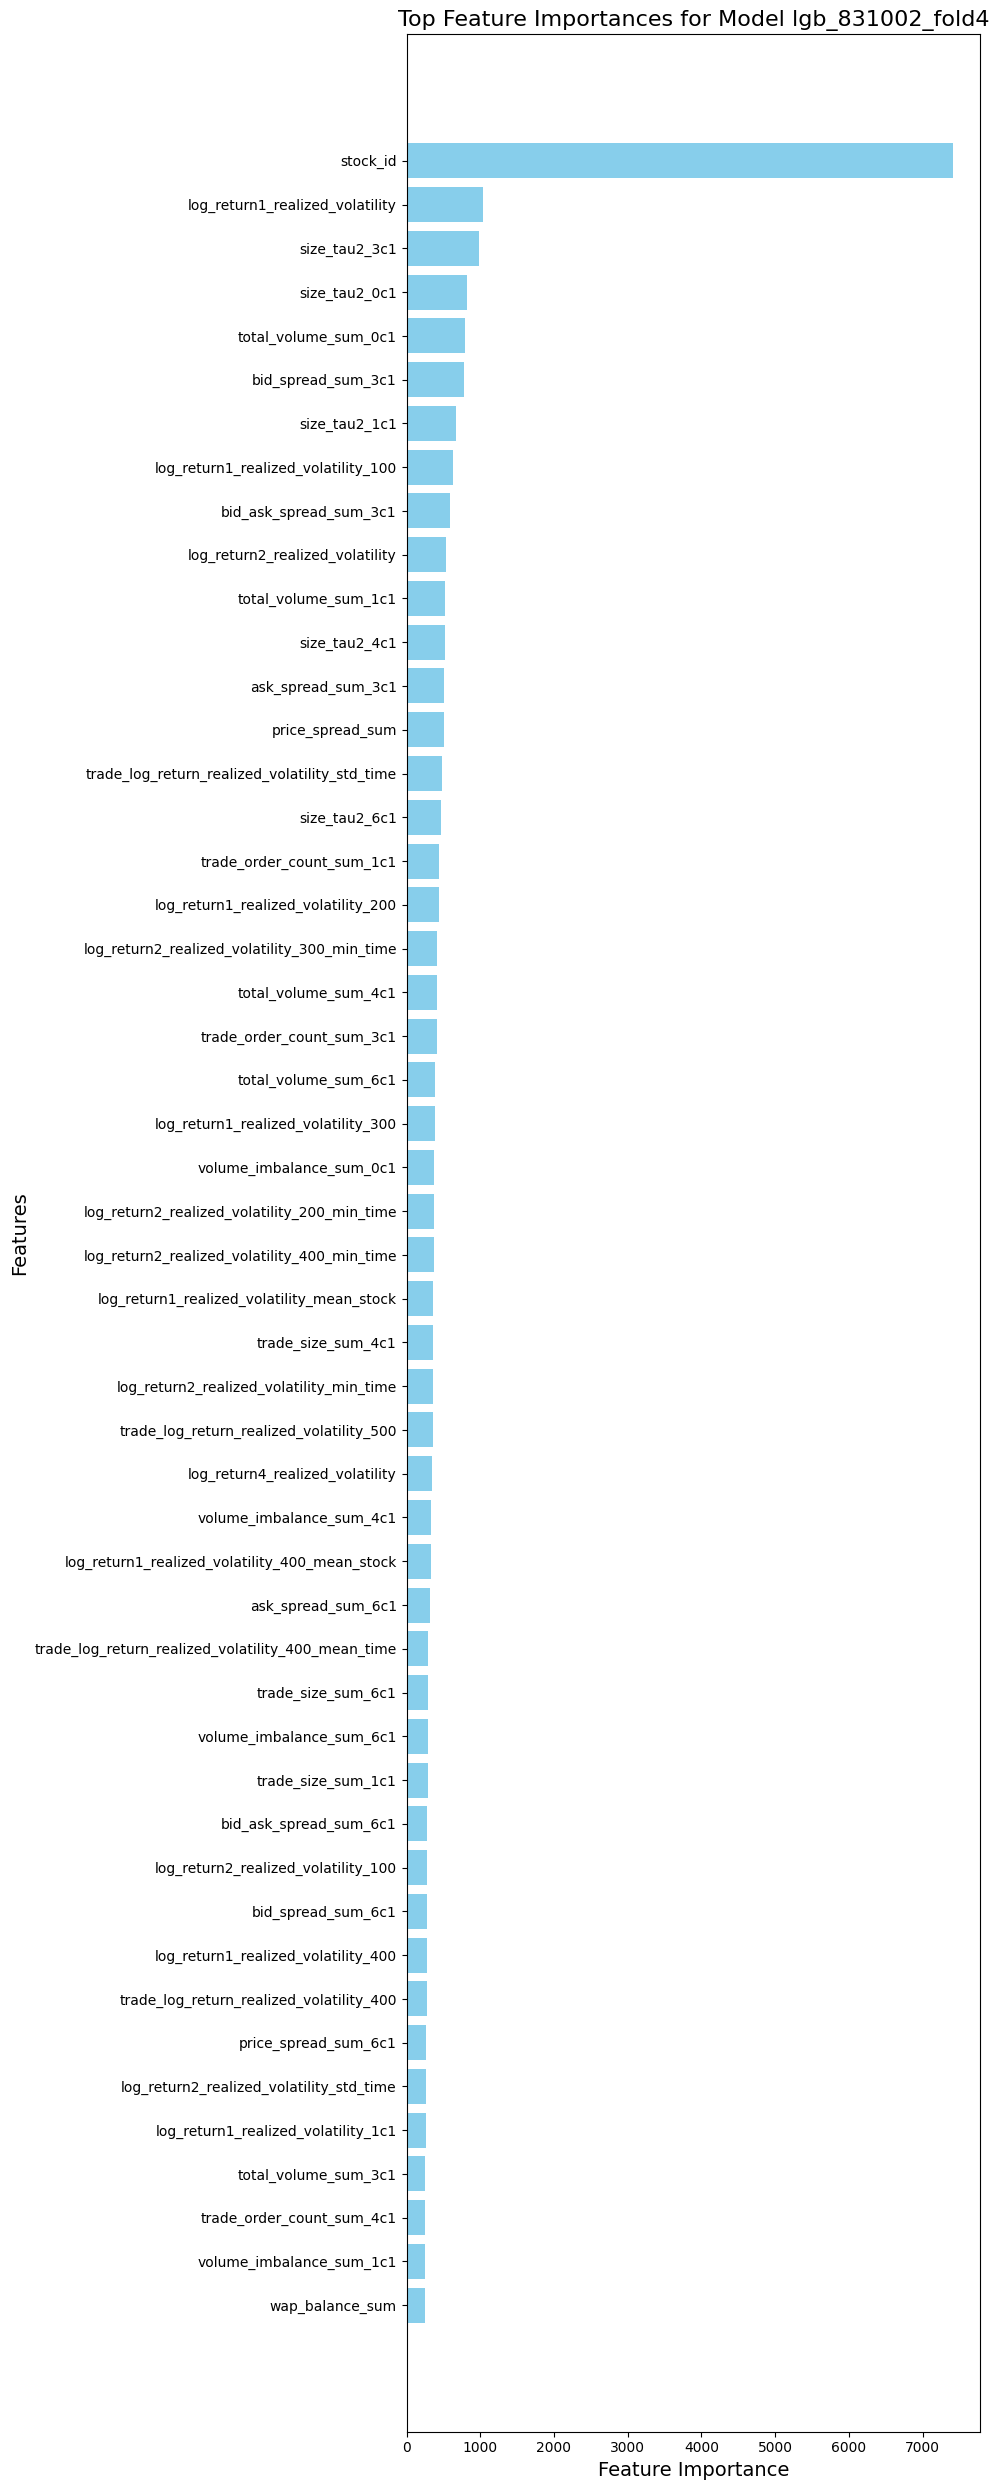

In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import os

# Set your output directory
output_dir = "/content/drive/My Drive/output"
feature_imp_file = 'lgb_feature_imp_831002_fold4.csv'

# Construct the full path to the feature importance file
feature_imp_path = os.path.join(output_dir, feature_imp_file)

# Load the feature importance data
feature_imp = pd.read_csv(feature_imp_path)

# Sort the feature importances and select the top N features for clearer plot
top_n = 50  # Change N to your preference for the number of top features to display
feature_imp_sorted = feature_imp.sort_values(by='Value', ascending=False).head(top_n)

# Create the plot with adjusted size and rotated feature names for clarity
plt.figure(figsize=(10, top_n / 2))  # Adjust the size as needed
plt.barh(feature_imp_sorted['Feature'], feature_imp_sorted['Value'], color='skyblue')
plt.xlabel('Feature Importance', fontsize=14)
plt.ylabel('Features', fontsize=14)
plt.title('Top Feature Importances for Model lgb_831002_fold4', fontsize=16)
plt.yticks(rotation=0)  # Rotate feature names
plt.gca().invert_yaxis()  # Invert y-axis to have the most important feature at the top
plt.tight_layout()  # Adjust layout to fit everything
plt.show()
